In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import sklearn.linear_model
import sklearn.metrics
import seaborn as sns
import tqdm.notebook as tqdm

In [2]:
pathlib.Path("data/fits").mkdir(exist_ok=True, parents=True)

In [3]:
def evaluate(beta, X, Y):
    Y_hat = X @ beta
    r2_scores = [sklearn.metrics.r2_score(y, yhat) for y, yhat in zip(Y.T.values, Y_hat.T.values)]
    return np.array(r2_scores)

In [4]:
X_orig = pl.read_csv("data/pheno/original.tsv", separator="\t", ).drop("FID", "IID").with_columns(intercept=1.0).to_pandas()
Y_orig = pl.read_csv("data/pheno/rand_original.tsv", separator="\t").to_pandas()

pheno_root = pathlib.Path("data/pheno")
anon_paths = sorted(pheno_root.glob("anon_*.tsv"))

summary_df = pd.DataFrame()
for anon_path in tqdm.tqdm(anon_paths):
    rand_path = pheno_root.joinpath(f"rand_{anon_path.stem}.tsv")
    assert rand_path.exists()

    X_anon = pl.read_csv(anon_path, separator="\t").drop("n_occurrences").with_columns(intercept=1.0).to_pandas()
    Y_anon = pl.read_csv(rand_path, separator="\t")
    phenotype_names = Y_anon.columns
    Y_anon = Y_anon.to_pandas()

    # beta, _, _, _ = np.linalg.lstsq(X_anon, Y_anon)
    model = sklearn.linear_model.Ridge(fit_intercept=False).fit(X_anon, Y_anon)
    beta = model.coef_.T

    r2_anon = evaluate(beta, X_anon, Y_anon)
    r2_orig = evaluate(beta, X_orig, Y_orig)

    this_df = pd.DataFrame({
        "anon": anon_path.stem,
        "k": int(anon_path.stem.split("_")[1]),
        "phenotype": phenotype_names,
        "r2_anon": r2_anon,
        "r2_orig": r2_orig,
    })
    summary_df = pd.concat([summary_df, this_df])

summary_df = (
    pl.DataFrame(summary_df)
    .with_columns(
        operator=pl.col("phenotype").str.extract("^([a-z]+)(?:_)")
    )
)
summary_df.write_parquet("data/fits/phenotype_fits.parquet")

summary_df.head(2)

  0%|          | 0/4 [00:00<?, ?it/s]

anon,k,phenotype,r2_anon,r2_orig,operator
str,i64,str,f64,f64,str
"""anon_005""",5,"""and_q_4123_0_q_4249_5""",0.757969,0.656834,"""and"""
"""anon_005""",5,"""and_q_5074_6_q_4247_10""",0.899422,0.827137,"""and"""


In [5]:
(
    summary_df
    .group_by("operator")
    .len()
)

operator,len
str,u32
"""and""",1368
"""mul""",1268
"""or""",1364


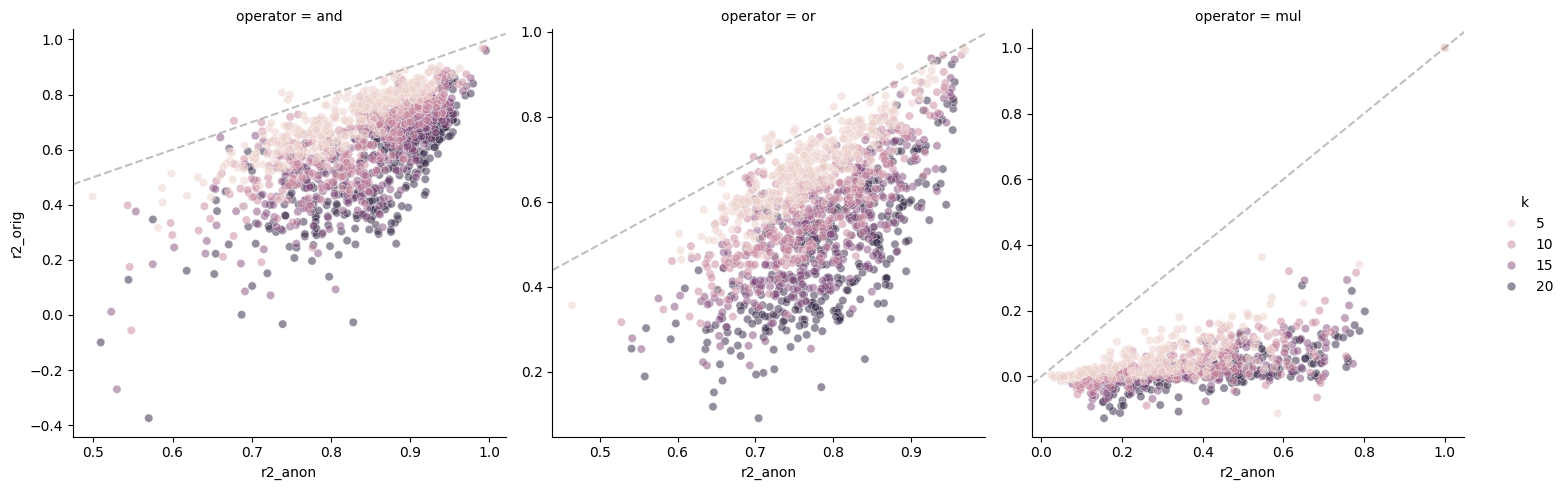

In [6]:
(
    summary_df
    .sort("k", descending=True)
    .pipe(sns.relplot, x="r2_anon", y="r2_orig", hue="k", col="operator", alpha=0.5, facet_kws=dict(sharex=False, sharey=False))
    .map(lambda *a, **k: plt.axline((0.9, 0.9), slope=1, linestyle="dashed", color="gray", alpha = 0.5))
)

In [7]:
y_hat_anon = (X_anon @ beta).values.ravel()
y_hat_orig = (X_orig @ beta).values.ravel()

y_anon = Y_anon.values.ravel()
y_orig = Y_orig.values.ravel()

r2_anon = 1 - np.square(Y_anon - (X_anon @ beta)).sum(axis=0) / np.maximum(1, np.square(Y_anon - Y_anon.mean(axis=0)).sum(axis=0))
r2_orig = 1 - np.square(Y_orig - (X_orig @ beta)).sum(axis=0) / np.maximum(1, np.square(Y_orig - Y_orig.mean(axis=0)).sum(axis=0))

Overall: 0.8832366832666657


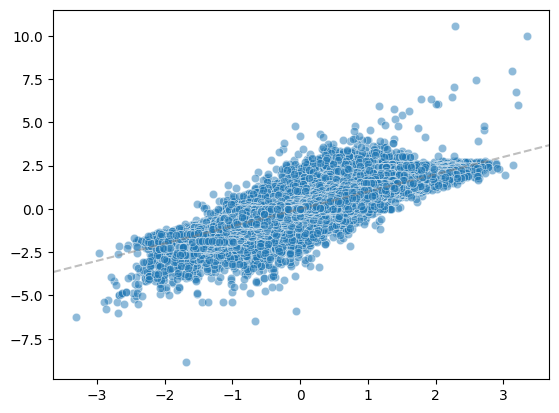

In [8]:
sns.scatterplot(x=(X_anon @ beta).values.ravel(), y=y_anon, alpha=0.5)
plt.axline((0.9, 0.9), slope=1, linestyle="dashed", color="gray", alpha = 0.5)
anon_r2 = 1 - np.square(y_anon - (X_anon @ beta).values.ravel()).sum() / np.square(y_anon - y_anon.mean()).sum()
print("Overall:", anon_r2)

In [ ]:
sns.scatterplot(x=(X_orig @ beta).values.ravel(), y=y_orig, alpha=0.5)
plt.axline((0.9, 0.9), slope=1, linestyle="dashed", color="gray", alpha = 0.5)
orig_r2 = 1 - np.square(y_orig - (X_orig @ beta).values.ravel()).sum() / np.square(y_orig - y_orig.mean()).sum()
print("Overall:", orig_r2)